In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=8789e4485e4ec728c9679af01ebf2fc4304de1c5a6d4cb7011d89e448132ce5b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
# Bắt đầu spark session nè
spark = SparkSession.builder \
    .appName("PCA") \
    .getOrCreate()

### ĐỌC DỮ LIỆU

In [ ]:
FILE_PATH = "/content/standardized_data.csv"

In [ ]:
data = spark.read.csv(FILE_PATH, header=True, inferSchema=True)

In [ ]:
data.show()

+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|              Income|            Kidhome|           Teenhome|            Recency|               Wines|              Fruits|                Meat|                Fish|              Sweets|                Gold|  NumDealsPurchases|     NumWebPurchases| NumCatalogPurchases|   NumStorePurchases|   NumWebVisitsMonth|         CustomerFor|                 Age|         Total_Spent|           Children|          Is_Parent|          Education|        Living_With|
+--------------------+-------------------+-------------------+-------------------+------

### XỬ LÝ PCA

#### Một số thông tin:
- Dữ liệu trước được sử dụng phải chuyển về dạng vector.

In [ ]:
# Lấy tên của các features
feature_columns = data.columns
# Lấy giá trị của từng dòng sau đó kết hợp thành 1 vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(data)

In [ ]:
assembled_df.show()

+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|              Income|            Kidhome|           Teenhome|            Recency|               Wines|              Fruits|                Meat|                Fish|              Sweets|                Gold|  NumDealsPurchases|     NumWebPurchases| NumCatalogPurchases|   NumStorePurchases|   NumWebVisitsMonth|         CustomerFor|                 Age|         Total_Spent|           Children|          Is_Parent|          Education|        Living_With|            features|
+--------------------+-------------------+----

In [ ]:
# Sử dụng PCA trên cột features, kết quả trả về là một vector đã được giảm chiều
# Xác định số chiều được giảm về là 3
pca =
 1

   (k=3, inputCol="features", outputCol="pca_features")
# fit model PCA với dữ liệu đã được tổng hợp từ trước
pca_model = pca.fit(assembled_df)
# Transform dataframe trước đó sử dụng pca model, kết quả trả về cột thuộc tính "pca_features"
pca_result = pca_model.transform(assembled_df)

In [ ]:
pca_result.show()

+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|              Income|            Kidhome|           Teenhome|            Recency|               Wines|              Fruits|                Meat|                Fish|              Sweets|                Gold|  NumDealsPurchases|     NumWebPurchases| NumCatalogPurchases|   NumStorePurchases|   NumWebVisitsMonth|         CustomerFor|                 Age|         Total_Spent|           Children|          Is_Parent|          Education|        Living_With|            features|        pca_features|
+---

In [ ]:
# Tạo hàm triết xuất user-defined function để lọc ra các PCs
def locPcs(index):
  # Chỗ này lấy giá trị thứ i của vector rồi trả về kiểu float
    def locIndex(vector):
        return float(vector[index])
         # Chỗ này trả về một hàm do người dùng xác định udf
    return udf(locIndex, DoubleType())

In [ ]:
# Sử dụng hàm locPcs để add vào dữ liệu từ trước 3 cột (tương ứng với 3 PCs)
pca_df = pca_result.withColumn("pc1", locPcs(0)(col("pca_features"))) \
                   .withColumn("pc2", locPcs(1)(col("pca_features"))) \
                   .withColumn("pc3", locPcs(2)(col("pca_features")))

In [ ]:
pca_df.show()

+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|              Income|            Kidhome|           Teenhome|            Recency|               Wines|              Fruits|                Meat|                Fish|              Sweets|                Gold|  NumDealsPurchases|     NumWebPurchases| NumCatalogPurchases|   NumStorePurchases|   NumWebVisitsMonth|         CustomerFor|                 Age|         Total_Spent|           Children|          Is_Parent|          Education|        Living_With|     

In [ ]:
# Chọn ra 3 cột PCs để giữ lại
pca_df = pca_df.select("pc1", "pc2", "pc3")

In [ ]:
# Xem xét các thống kê mô tả
pca_df.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|                 pc1|                 pc2|                 pc3|
+-------+--------------------+--------------------+--------------------+
|  count|                2212|                2212|                2212|
|   mean|8.331691776120071...|1.485651063693699...|6.566226365125954...|
| stddev|   2.814810602745994|  1.6165138112305295|  1.2113973832221085|
|    min|   -7.51614580978999|  -5.600904884045589|  -5.982727814930029|
|    max|   5.694811654471698|  3.7192861019498094|  3.4281694046819537|
+-------+--------------------+--------------------+--------------------+



In [ ]:
# TẢI VỀ DATASET PCA
ds_download = pca_df.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
ds_download.to_csv('pca_data.csv', index=False)

In [ ]:
# Chuyển dữ liệu về dạng pandas dataframe để có thể trực quan hóa
plot_pca_df = pca_df.toPandas()


In [ ]:
# Xác định cột x, y, z tương ứng với các PCs
x = plot_pca_df["pc1"]
y = plot_pca_df["pc2"]
z = plot_pca_df["pc3"]

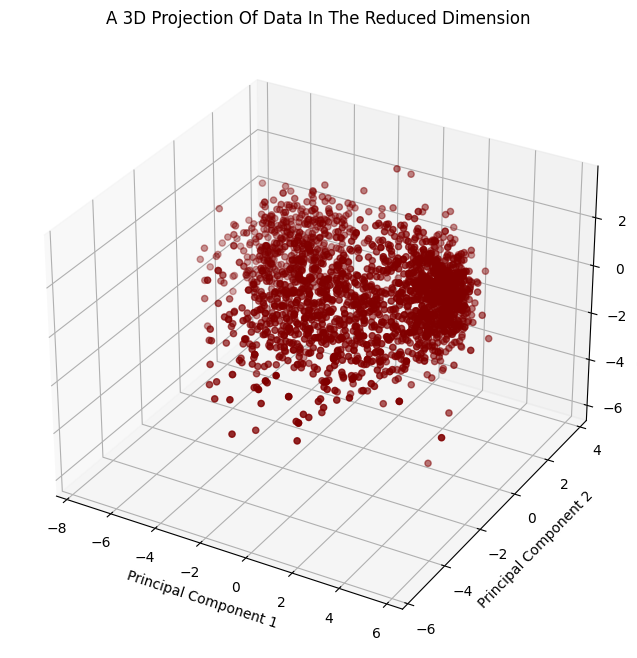

In [ ]:
# Trực quan dữ liệu sử dụng thư viện Matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c="maroon", marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()